In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# 데이터 준비

28577_36420_compressed_fer2013.csv.zip 파일을 https://www.kaggle.com/deadskull7/fer2013 에서 다운 받은 후에 google drive에 올린다.


데이터 로딩하고 준비하는 코드는 https://github.com/SagarPatel98/Human-Facial-Emotion-Recognition---Keras/blob/master/Facial%20Recognition.ipynb 에서 가져왔다.

## 다운로드

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!cp '/content/drive/My Drive/tmp/t/28577_36420_compressed_fer2013.csv.zip' ./

In [4]:
!unzip 28577_36420_compressed_fer2013.csv.zip

Archive:  28577_36420_compressed_fer2013.csv.zip
  inflating: fer2013.csv             


## 살펴보기

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from matplotlib.colors import ListedColormap
import seaborn as sns

import cv2

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
df = pd.read_csv("fer2013.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
print(df.shape)

(35887, 3)


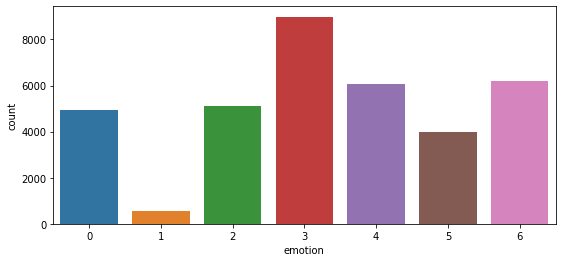

In [8]:
plt.figure(figsize=(9,4))
sns.countplot(x='emotion', data=df)

In [9]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

emotion 컬럼의 값은 다음을 의미.

0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

1(disgust)의 수가 너무 적다.

0(angry)와 1(disgust)를 합친다.

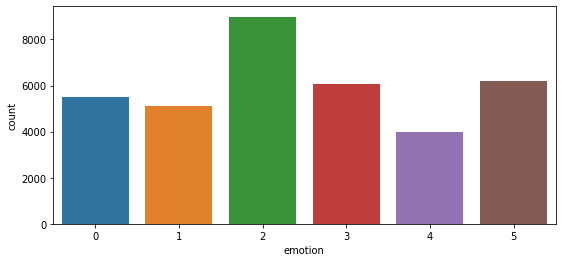

In [10]:
df['emotion'] = df['emotion'].map( {0:0, 1:0, 2:1, 3:2, 4:3, 5:4, 6:5} ).astype(int)
plt.figure(figsize=(9,4))
sns.countplot(x='emotion', data=df)

In [27]:
category_names = [ "angry", "fear", "happy", "sad", "suprise", "neutral" ]

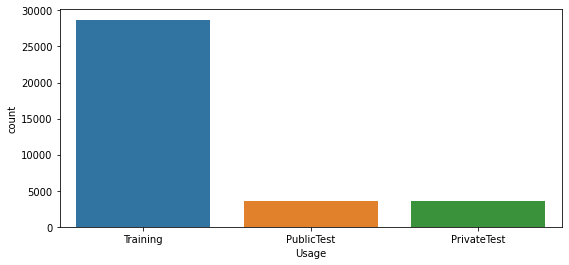

In [11]:
plt.figure(figsize=(9,4))
sns.countplot(x='Usage', data=df)

In [12]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

## 얼굴 데이터 구하기

받은 csv파일에 얼굴 영상의 pixel 값이 숫자로 그냥 들어 있다.
이를 읽어서 데이터를 준비하자.

In [13]:
image_size=(48,48)

In [14]:
pixels = df['pixels'].tolist()
width, height = 48, 48
faces = []

for pixel_sequence in pixels:
  face = [int(pixel) for pixel in pixel_sequence.split(' ')]
  face = np.asarray(face).reshape(width, height)
  face = cv2.resize(face.astype('uint8'),image_size)
  faces.append(face.astype('float32'))
  
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
print(faces.shape)

(35887, 48, 48, 1)


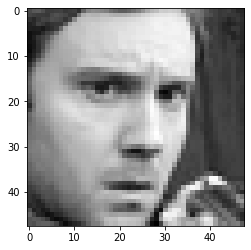

In [15]:
plt.imshow(faces[0].squeeze(), cmap="gray")

## Normalization

In [16]:
print(np.min(faces), np.max(faces))
faces = faces / 255.0
print(np.min(faces), np.max(faces))

0.0 255.0
0.0 1.0


## emotion 데이터 구하기

In [17]:
emotions = df['emotion'].values
print(emotions.shape)
print(emotions)

(35887,)
[0 0 1 ... 0 2 1]


## 데이터 나누기

In [18]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(faces, emotions, test_size=0.2)

In [19]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(28709, 48, 48, 1)
(28709,)
(7178, 48, 48, 1)
(7178,)


# 모델 정의

In [20]:
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPool2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array


model = models.Sequential()

model.add(Input(train_x.shape[1:]))
model.add(Conv2D(32, (3,3), padding="same"))
model.add(MaxPool2D())
model.add(Conv2D(64, (3,3), padding="same"))
model.add(MaxPool2D())
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# 데이터 증강

In [21]:
train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
)

test_data_generator = ImageDataGenerator()

# 학습

In [22]:
model.fit_generator(
      train_data_generator.flow(train_x, train_y, 32),
      validation_data=test_data_generator.flow(test_x, test_y, 32),
      steps_per_epoch=len(train_x)/32,  
      validation_steps=len(test_x)/32,      
      epochs=10
)

Epoch 1/10
898/897 [==============================] - 18s 20ms/step - loss: 1.6854 - acc: 0.3240 - val_loss: 1.4652 - val_acc: 0.4142
Epoch 2/10
898/897 [==============================] - 11s 12ms/step - loss: 1.5045 - acc: 0.4018 - val_loss: 1.3877 - val_acc: 0.4533
Epoch 3/10
898/897 [==============================] - 11s 13ms/step - loss: 1.4574 - acc: 0.4288 - val_loss: 1.3752 - val_acc: 0.4723
Epoch 4/10
898/897 [==============================] - 11s 12ms/step - loss: 1.4294 - acc: 0.4431 - val_loss: 1.3156 - val_acc: 0.4893
Epoch 5/10
898/897 [==============================] - 11s 13ms/step - loss: 1.4139 - acc: 0.4463 - val_loss: 1.2979 - val_acc: 0.4967
Epoch 6/10
898/897 [==============================] - 11s 12ms/step - loss: 1.4062 - acc: 0.4550 - val_loss: 1.3575 - val_acc: 0.4813
Epoch 7/10
898/897 [==============================] - 11s 12ms/step - loss: 1.4015 - acc: 0.4565 - val_loss: 1.2929 - val_acc: 0.5018
Epoch 8/10
898/897 [==============================] - 11s 12ms

# 평가

In [23]:
loss, acc = model.evaluate_generator(
      test_data_generator.flow(test_x, test_y, 32),
      steps=len(test_x)/32
)
print(loss, acc)

1.3320934452961402 0.49749234


# 결과 보기

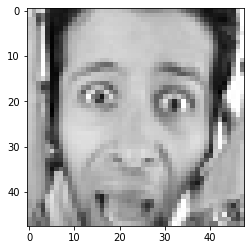

predicted category index = 4
suprise


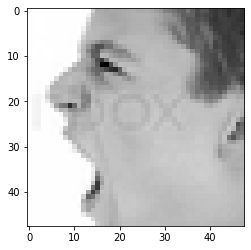

predicted category index = 1
fear


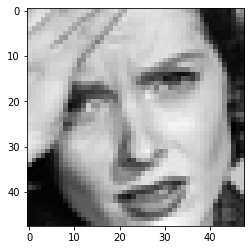

predicted category index = 1
fear


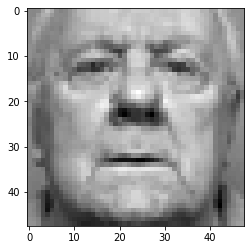

predicted category index = 5
neutral


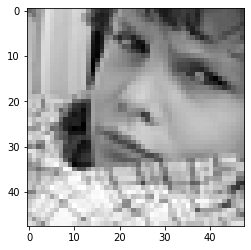

predicted category index = 2
happy


In [30]:
y_ = model.predict(test_x)

predicted = np.argmax(y_, axis=1)

for i in range(5):
  plt.imshow(test_x[i].squeeze(), cmap="gray")
  plt.show()
  print("predicted category index =", predicted[i])
  print(category_names[predicted[i]])
